In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.smoother import GaussianSmoother
import spikeinterface
import spikeinterface.full as si

import helper_functions as helper
from spikeinterface.sorters import run_sorter_local

# Load the data

In [52]:
local_path= '/mnt/disk20tb/mandar/stims/Trace_20240411_16_43_18.raw.h5' #network data from chip 16848


recording1 = si.read_maxwell(local_path,stream_id='well000')

#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#end_time = int((total_recording-1))
start_time = 230
end_time = 430

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = si.bandpass_filter(recording1, freq_min=300, freq_max=3000)

recodring_cmr = si.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= start_time*fs,end_frame=end_time*fs)
#recording_chunk =si.scale(recording_chunk, gain=3.0)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")

Sampling frequency: 20000.0
Number of channels: 587
Number of segments: 1
total_recording: 1051.09 s
chunk duration: 200.0 s


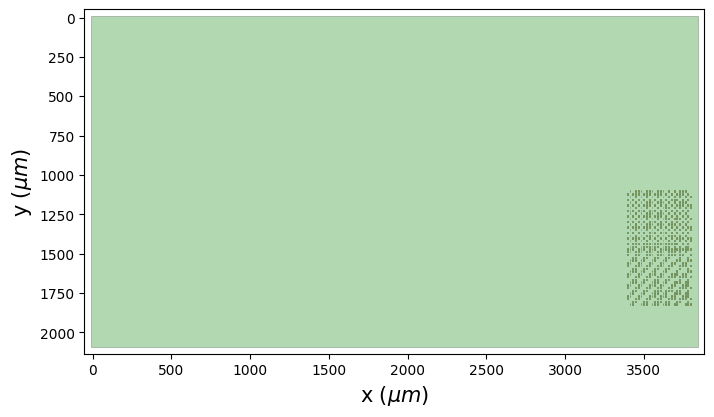

In [3]:
fig,ax = plt.subplots(figsize=(8,8))
si.plot_probe_map(recording1,ax=ax,with_channel_ids=False)
ax.invert_yaxis()

In [ ]:
traces = recording_chunk.get_traces(start_frame=100, end_frame=50000*15, segment_index=0,return_scaled=True)


In [32]:
# Assuming recording_chunk.get_channel_ids() returns a list of channel IDs
channel_ids = recording_chunk.get_channel_ids()

# Specify the particular channel ID you are interested in
specific_channel_id = '580' # Replace `desired_channel_id` with the actual ID you're looking for

index = np.where(np.array(channel_ids) == specific_channel_id)[0][0]
index

544

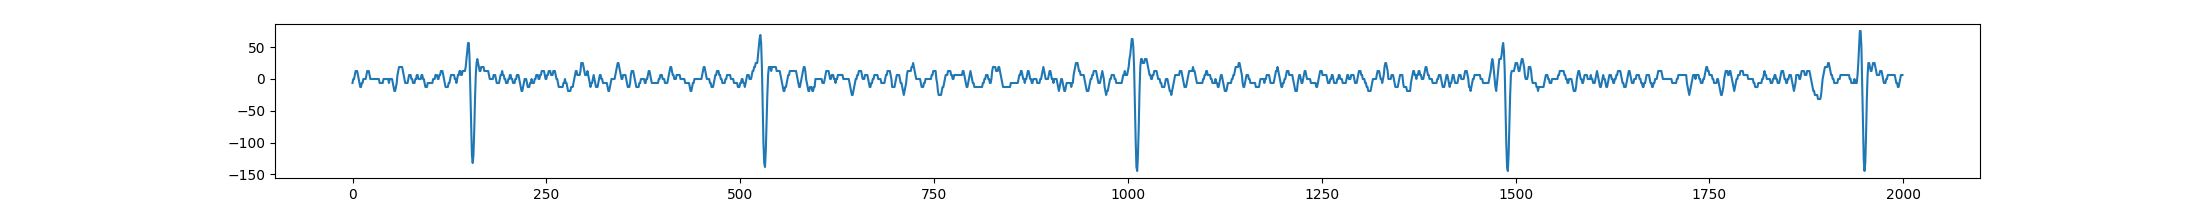

In [54]:
traces = recording_chunk.get_traces(start_frame=208550, end_frame=210550, segment_index=0,return_scaled=True)
plt.figure(figsize=(22,2))                                                                                                                                                                                                                                                              
plt.plot(traces[:,389])
plt.savefig('/home/mmp/Documents/traces/fulltrace_oragnoid_802F.svg',format='svg')           
plt.show()

In [53]:
%matplotlib widget
si.plot_traces(recording=recording_chunk,backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [108]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
job_kwargs = dict(n_jobs=32, chunk_duration='1s', progress_bar=True)
noise_levels_int16 = si.get_noise_levels(recording_chunk,return_scaled=True)
peaks = detect_peaks(recording_chunk,  method='by_channel', peak_sign ="neg", noise_levels=noise_levels_int16,
                     detect_threshold=10, **job_kwargs)


detect peaks using by_channel:   0%|          | 0/200 [00:00<?, ?it/s]

In [122]:
import numpy as np
import scipy.signal

def detect_peaks(trace, peak_sign, abs_threshold):
    peaks_sample_inds = []
    peaks_chan_inds = []

    if peak_sign in ("pos", "both"):
        peaks, _ = scipy.signal.find_peaks(trace, height=abs_threshold)
        peaks_sample_inds.extend(peaks)
        peaks_chan_inds.extend([0] * len(peaks))

    if peak_sign in ("neg", "both"):
        peaks, _ = scipy.signal.find_peaks(-trace, height=abs_threshold)
        peaks_sample_inds.extend(peaks)
        peaks_chan_inds.extend([0] * len(peaks))

    return np.array(peaks_sample_inds), np.array(peaks_chan_inds)
    

# def detect_peaks(traces, peak_sign, abs_thresholds):
#     peaks_sample_inds = []
#     peaks_chan_inds = []
#     for chan in range(traces.shape[1]):
#         if peak_sign in ("pos", "both"):
#             peaks, _ = scipy.signal.find_peaks(traces[:, chan], height=abs_thresholds)
#             peaks_sample_inds.extend(peaks)
#             peaks_chan_inds.extend([chan] * len(peaks))
        
#         if peak_sign in ("neg", "both"):
#             peaks, _ = scipy.signal.find_peaks(-traces[:, chan], height=abs_thresholds)
#             peaks_sample_inds.extend(peaks)
#             peaks_chan_inds.extend([chan] * len(peaks))
    
#     return np.array(peaks_sample_inds), np.array(peaks_chan_inds)
channel_list = recording_chunk.get_channel_ids()
traces = recording_chunk.get_traces(start_frame=290000, end_frame=295000, segment_index=0,return_scaled=False)
x,y = detect_peaks(traces[:,np.where(channel_list == '899')[0][0]], peak_sign="neg", abs_threshold=5.5)

In [123]:
print(x,y)

[2243] [0]


In [117]:
print(traces[:,np.where(channel_list == '899')[0][0]].shape[1])

IndexError: tuple index out of range

In [ ]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

peak_locations = localize_peaks(rec, peaks, method='center_of_mass', radius_um=50., **job_kwargs)


(5000, 587)


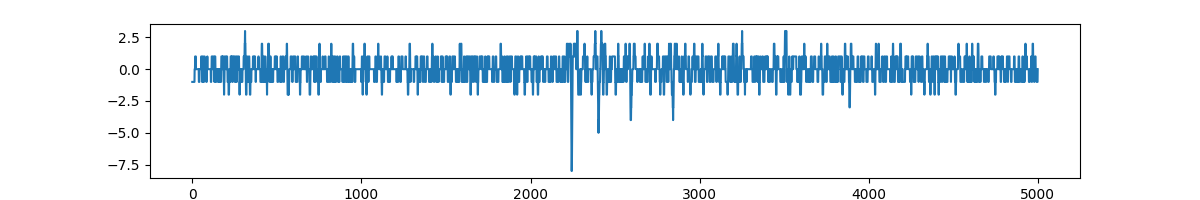

In [121]:
channel_list = recording_chunk.get_channel_ids()
traces = recording_chunk.get_traces(start_frame=290000, end_frame=295000, segment_index=0,return_scaled=False)
print(traces.shape)
plt.figure(figsize=(12,2))
plt.plot(traces[:,np.where(channel_list == '899')[0][0]])
#plt.savefig('/home/mmp/Documents/traces/zoomednp.where(channel_list == '839')[0]in.svg',format='svg')
plt.show()

## RUnnig sorting

In [4]:
#aggregated_rec= aggregated_rec.save(fodler="./sorting/recordingtest",progress_bar=True,verbose=True)
output_folder = "./sorting/stim_baseline3min_KS"
docker_image= "rohanmalige/benshalom:v3"
default_KS2_params = si.get_default_sorter_params('kilosort2')
print(default_KS2_params)
#default_KS2_params['keep_good_only'] = True
default_KS2_params['detect_threshold'] = 5.5
# default_KS2_params['projection_threshold']=[18, 10]
default_KS2_params['n_jobs'] = 32
# global_job_kwargs = dict(n_jobs=32, total_memory="8G", progress_bar=True)
# si.set_global_job_kwargs(**global_job_kwargs)
run_sorter = si.run_sorter('kilosort2',recording=recording_chunk, output_folder=output_folder,docker_image= docker_image,verbose=True,remove_existing_folder=True, **default_KS2_params)

## if running on NERSC:
#run_sorter_local("kilosort2",recording_chunk, output_folder="./sorting/FolicAcid10mg", delete_output_folder=False,verbose=True,with_output=True,**default_KS2_params)
#run_sorter = ss.run_sorter('kilosort2',recording= recording_chunk, output_folder="/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/kilosort2",docker_image= True,verbose=True, **default_KS2_params)

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'momentum': [20.0, 400.0], 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'freq_min': 150, 'sigmaMask': 30, 'lam': 10.0, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': ('matlab_files',), 'delete_recording_dat': False, 'n_jobs': 48, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}
installation_mode='auto' switching to installation_mode: 'github'
Starting container
Installing neo with pypi in container
Installing h5py with pypi in container
Running kilosort2 sorter inside rohanmalige/benshalom:v3
Stopping container


In [5]:

# loading the KS2 sorted object
sortingKS3 = run_sorter.remove_empty_units()
sortingKS3 = si.remove_excess_spikes(sortingKS3,recording1) #Sometimes KS returns spikes outside the number of samples. < https://github.com/SpikeInterface/spikeinterface/pull/1378>

sortingKS3= sortingKS3.save(folder = f'{output_folder}2',overwrite=True)
#sorting_KS3 = s.Kilosort2Sorter._get_result_from_folder('./sorting/FolicAcidT2M07038_2_KS/sorter_output')
total_units = sortingKS3.get_unit_ids()
print(len(total_units))
#print(len(total_units))
channel_ids = recording_chunk.get_channel_ids()
print(channel_ids)



154
['1' '3' '5' '7' '9' '11' '13' '15' '17' '19' '21' '23' '25' '27' '29'
 '31' '33' '35' '37' '39' '41' '43' '45' '47' '49' '51' '53' '55' '57'
 '59' '61' '63' '65' '67' '69' '71' '73' '75' '77' '79' '81' '83' '85'
 '87' '89' '91' '93' '95' '97' '99' '101' '103' '105' '107' '109' '111'
 '113' '115' '117' '119' '121' '123' '125' '127' '129' '131' '133' '135'
 '137' '139' '141' '143' '145' '147' '149' '151' '153' '155' '157' '159'
 '161' '163' '165' '167' '169' '171' '173' '175' '177' '179' '181' '183'
 '185' '187' '189' '191' '193' '195' '197' '199' '201' '203' '205' '207'
 '209' '211' '213' '215' '217' '219' '221' '223' '225' '227' '229' '231'
 '233' '235' '237' '239' '241' '243' '245' '247' '249' '251' '253' '255'
 '257' '259' '261' '263' '265' '267' '269' '271' '273' '275' '277' '279'
 '281' '283' '285' '287' '289' '291' '293' '295' '297' '299' '301' '303'
 '305' '307' '309' '311' '313' '315' '317' '319' '321' '323' '325' '327'
 '329' '331' '333' '335' '337' '339' '341' '343' '345'

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/core/basesorting.py:239: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")



job_kwargs = dict(n_jobs=32, chunk_duration="1s", progress_bar=False)
sorting_analyzer = spikeinterface.core.create_sorting_analyzer(sortingKS3, recording_chunk,
                                              format="binary_folder", folder="./my_sorting_analyzer",
                                              **job_kwargs)
sorting_analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
sorting_analyzer.compute("waveforms", **job_kwargs)
sorting_analyzer.compute("templates")
sorting_analyzer.compute("noise_levels")
sorting_analyzer.compute("unit_locations", method="monopolar_triangulation")
sorting_analyzer.compute("isi_histograms")
sorting_analyzer.compute("correlograms", window_ms=100, bin_ms=5.)
sorting_analyzer.compute("principal_components", n_components=3, mode='by_channel_global', whiten=True, **job_kwargs)
sorting_analyzer.compute("quality_metrics", metric_names=["snr", "firing_rate"])
sorting_analyzer.compute("spike_amplitudes", **job_kwargs)

In [9]:
sortingKS3 = si.Kilosort2Sorter._get_result_from_folder("./sorting/KCNT1_T3_NeuronalScan_063_1_KS/sorter_output")

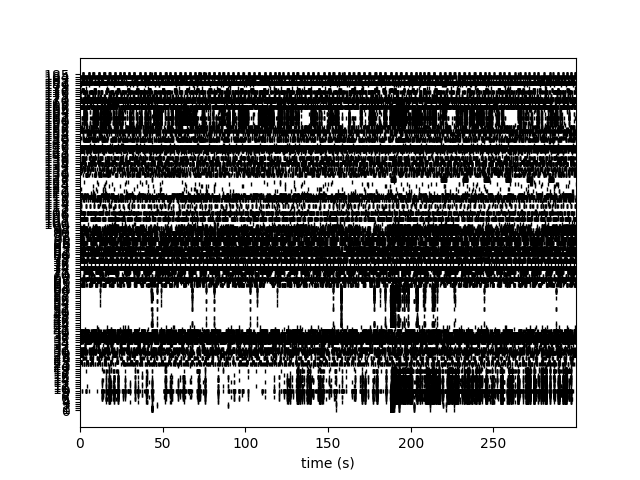

In [10]:
%matplotlib widget
si.plot_unit_templates)

## Extracting the waveforms

In [6]:

job_kwargs = dict(n_jobs=32, chunk_duration="1s", progress_bar=True)
#waveforms = si.extract_waveforms(recording_chunk,sorting_KS3,folder="./waveformsblock1_7min",overwrite=True, ms_before=1., ms_after=2.,**job_kwargs)

#recording1.annotate(is_filtered=True)
waveforms = si.extract_waveforms(recording_chunk,sortingKS3,folder='./sorting/stim_baseline3min_WF',sparse=False,overwrite=True,**job_kwargs)
print(waveforms)

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 587 channels - 154 units - 1 segments
  before:20 after:40 n_per_units:500


In [4]:
waveforms = si.load_waveforms('./sorting/KCNT1_T3_NeuronalScan_063_1_WF')

In [7]:
metrics = si.compute_quality_metrics(waveforms, n_jobs=32, progress_bar=True)

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1221: UserWarning: Amplitude PDF does not have a unique minimum! More spikes might be required for a correct amplitude_cutoff computation!
  warnings.warn(
/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:848: UserWarning: Units [0, 1, 2, 3, 10, 16, 17, 19, 20, 24, 26, 32, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 65, 69, 73, 75, 76, 79, 81, 84, 88, 91, 100, 101, 105, 106, 111, 112, 113, 114, 115, 120, 121, 122, 123, 124, 125, 127, 128, 130, 131, 133, 136, 140, 141, 147, 148, 150, 152, 156, 158, 167, 168, 173, 175, 178, 179, 183] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and " "amplitude_cutoff is set to NaN")
/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:702: UserWarning: 
  warnings.warn("")
/home/mmp/.local/

In [20]:
import numpy as np
# Calculate z-scores
z_scores = (metrics['amplitude_median'] - metrics['amplitude_median'].mean()) / metrics['amplitude_median'].std()

# Find outliers
outliers = metrics[z_scores.abs() > 3]

# Print outliers
print(outliers)


     amplitude_cutoff  amplitude_cv  amplitude_median  firing_range   
127               NaN           NaN       1825.332642          4.83  \
148               NaN           NaN       1608.181030          0.20   

     firing_rate  isi_violations_ratio  isi_violations_count  num_spikes   
127     0.700000            315.192744                 139.0       210.0  \
148     0.026667              0.000000                   0.0         8.0   

     presence_ratio  rp_contamination  rp_violations  sd_ratio   
127             0.6               1.0          208.0       NaN  \
148             0.6               0.0            0.0       NaN   

     sliding_rp_violation        snr  sync_spike_2  sync_spike_4  sync_spike_8  
127                   NaN  42.577427      0.033333         0.000           0.0  
148                   NaN  65.453613      0.125000         0.125           0.0  


In [21]:
import mea_analysis_pipeline as msp
import importlib
importlib.reload(msp)
update_metrics = msp.remove_violated_units(metrics,amplitude_median_thresh=20)

In [22]:

non_violated =  update_metrics.index.values
non_violated

array([ 23,  26,  28,  30,  33,  34,  35,  37,  39,  40,  62,  66,  69,
        70,  71,  75,  78,  80,  86,  90,  92, 103, 108, 111, 113, 116,
       117, 119, 129, 130, 131, 132, 133, 134, 135, 138, 141, 143, 145,
       150, 155, 156, 157, 166, 167, 170, 171, 182, 184, 185])

In [23]:
waveforms_good = waveforms.select_units(non_violated)
import spikeinterface_gui
app = spikeinterface_gui.mkQApp() 

    # create the mainwindow and show
win = spikeinterface_gui.MainWindow(waveforms_good)
win.show()
    # run the main Qt6 loop
app.exec_()

0

In [27]:
sparsity = si.compute_sparsity(waveforms_good,method="radius",radius_um=100)
we_good_sparse = waveforms_good.save(folder="./sorting/stim_baseline3min_WFsparse",sparsity=sparsity,overwrite=True)

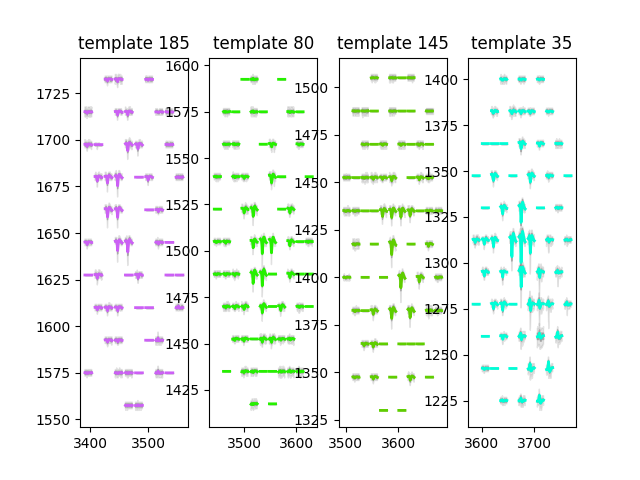

In [28]:

plots= si.plot_unit_templates(we_good_sparse,unit_ids=[185,80,145,35])

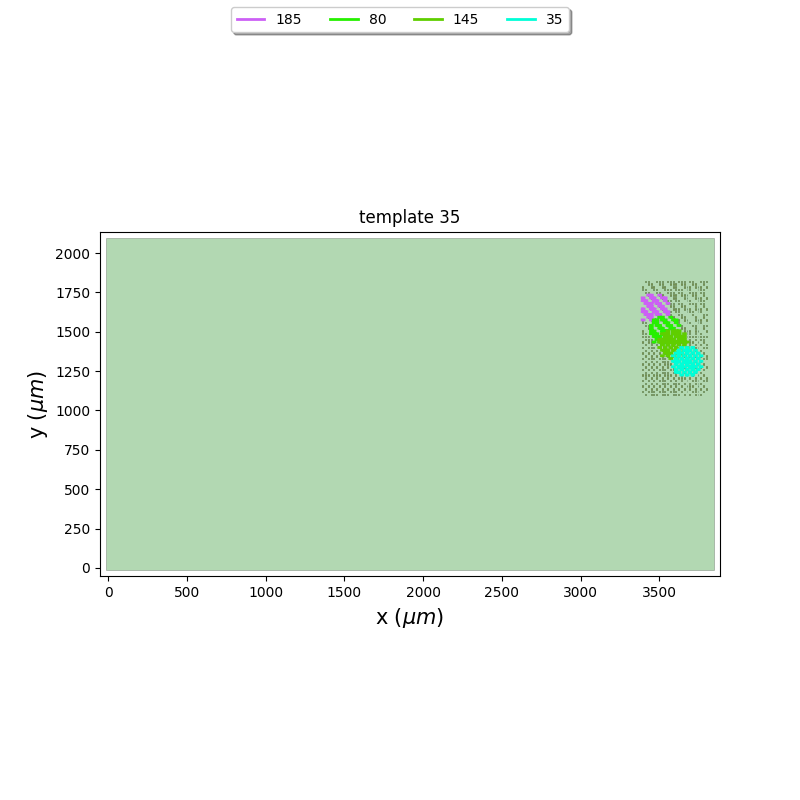

In [51]:
fig,ax = plt.subplots(figsize=(8,8))
si.plot_probe_map(recording1,ax=ax,with_channel_ids=False)

si.plot_unit_templates(we_good_sparse,unit_ids=[185,80,145,35],ax=ax,same_axis=True)
fig.savefig('/home/mmp/Documents/Organoid_intelligence_Grant/templatesonelectrodes.svg',format='svg')
#ax.invert_yaxis()


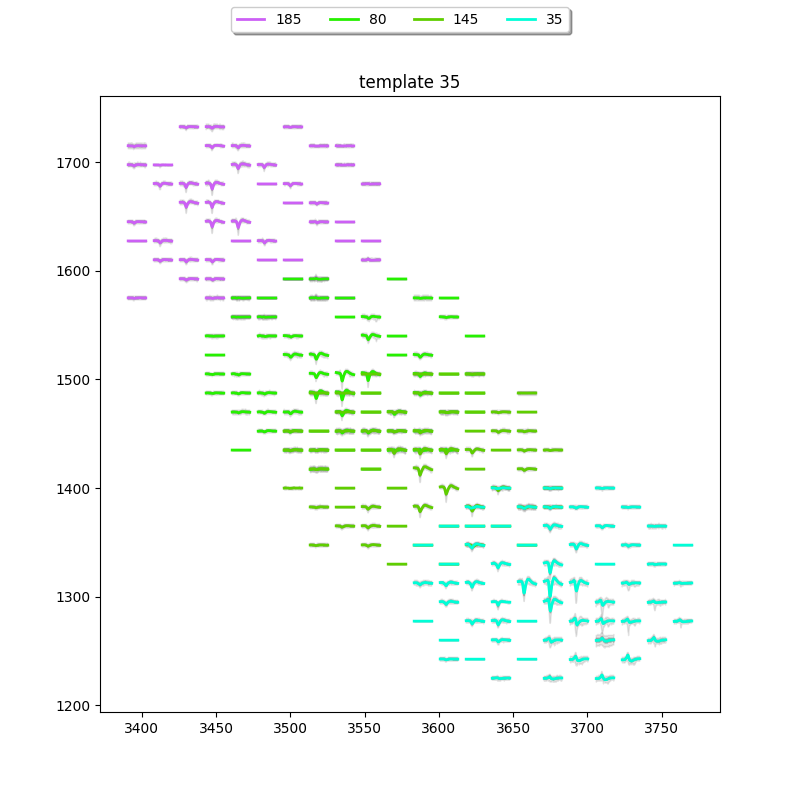

In [50]:
fig,ax = plt.subplots(figsize=(8,8))
si.plot_unit_templates(we_good_sparse,unit_ids=[185,80,145,35],ax=ax,same_axis=True)
fig.savefig('/home/mmp/Documents/Organoid_intelligence_Grant/unit_templates.svg',format='svg')

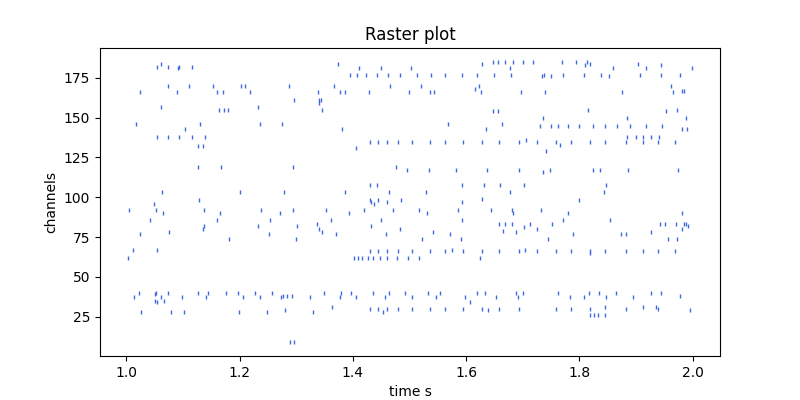

In [13]:
fig, ax1 = plt.subplots(figsize=(8,4))
spike_times = {}
for idx, unit_id in enumerate(waveforms.unit_ids):
    #print(unit_id)
    spike_train = sortingKS3.get_unit_spike_train(unit_id,start_frame=1*fs,end_frame=2*fs)
    #print(spike_train)
    if len(spike_train) > 0:
        spike_times[idx] = spike_train / float(fs)
        #print(spike_times[unit_id])
       # print(unit_id*np.ones_like(spike_times[unit_id]))
        # ax1.plot(spike_times[idx],waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))])*np.ones_like(spike_times[idx]),
        #                      marker='|', mew=1, markersize=3,
        #                      ls='',color='royalblue')
        ax1.plot(spike_times[idx],unit_id*np.ones_like(spike_times[idx]),
                             marker='|', mew=1, markersize=3,
                             ls='',color='royalblue')
        ax1.set_title('Raster plot')
        ax1.set_xlabel('time s')
        ax1.set_ylabel("channels")
        #ax1.set_yticks(range(16))
#plt.savefig('./plots/sortedunitsraster.pdf',format='pdf')

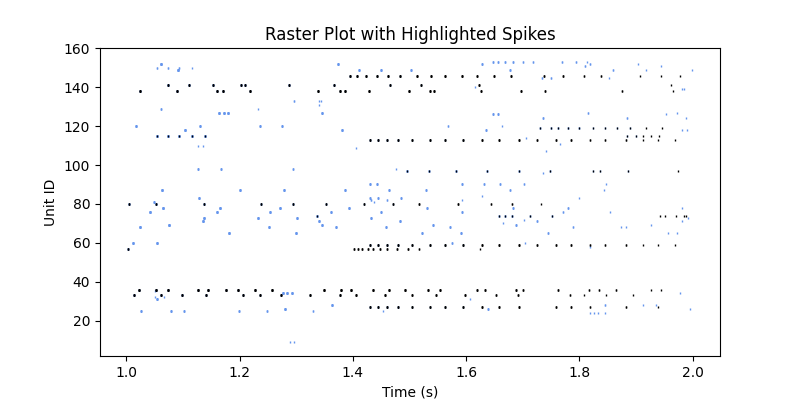

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
window_size = 1.0  # seconds
step_size = 0.1    # seconds
threshold = 10 / window_size   # Hz

# Preparation for optimized plotting
spike_times_red = []  # Spikes exceeding threshold
spike_indices_red = []
spike_times_blue = []  # Spikes below threshold
spike_indices_blue = []

# Use vectorized operations for moving window analysis
for idx, spike_times_array in spike_times.items():
    end_times = np.arange(window_size, np.max(spike_times_array) + step_size, step_size)
    start_times = end_times - window_size
    
    # Compute the number of spikes in each window using vectorization
    for start_time, end_time in zip(start_times, end_times):
        spikes_in_window = spike_times_array[(spike_times_array >= start_time) & (spike_times_array < end_time)]
        spiking_rate = len(spikes_in_window) / window_size
        
        # Classify and collect spikes based on threshold
        if spiking_rate >= threshold:
            spike_times_red.extend(spikes_in_window)
            spike_indices_red.extend([idx] * len(spikes_in_window))
        else:
            spike_times_blue.extend(spikes_in_window)
            spike_indices_blue.extend([idx] * len(spikes_in_window))

# Plotting in a single call per color
plt.figure(figsize=(8, 4))
plt.plot(spike_times_blue, spike_indices_blue,marker= '|',color='cornflowerblue', markersize=1,ls='', label='Below Threshold')
plt.plot(spike_times_red, spike_indices_red, marker='|',color='black', markersize=1, ls='',label='Above Threshold')
plt.title('Raster Plot with Highlighted Spikes')
plt.xlabel('Time (s)')
plt.ylabel('Unit ID')
#plt.legend()
plt.show()

In [ ]:
window_size = 1.0  # Window size in seconds
step_size = 0.1    # Step size in seconds
threshold = 50 /window_size    # Spiking rate threshold in Hz

# Placeholder for demonstration: replace with your method to obtain unit IDs and spike trains
 # Example unit IDs
#get_unit_spike_train = lambda unit_id, start_frame, end_frame: np.array([...])  # Example function

# Initialize lists for classified spike times
spike_times_below_threshold = []
spike_indices_below_threshold = []
spike_times_above_threshold = []
spike_indices_above_threshold = []

# Process each unit
for unit_id in waveforms.unit_ids:
    spike_train = sorting_KS3.get_unit_spike_train(unit_id, start_frame=0, end_frame=120*fs)
    print(spike_train)
    spike_times = spike_train / fs  # Convert to seconds

    # Moving window analysis
    for window_start in np.arange(0, np.max(spike_times), step_size):
        window_end = window_start + window_size
        spikes_in_window = spike_times[(spike_times >= window_start) & (spike_times < window_end)]

        # Calculate the spiking rate
        spiking_rate = len(spikes_in_window) / window_size

        # Classify and store spike times based on the threshold
        if spiking_rate >= threshold:
            spike_times_above_threshold.extend(spikes_in_window)
            spike_indices_above_threshold.extend([unit_id] * len(spikes_in_window))
        else:
            spike_times_below_threshold.extend(spikes_in_window)
            spike_indices_below_threshold.extend([unit_id] * len(spikes_in_window))

# Visualization
plt.figure(figsize=(8, 4))
plt.plot(spike_times_blue, spike_indices_blue,marker= '|',color='cornflowerblue', markersize=1,ls='', label='Below Threshold')
plt.plot(spike_times_red, spike_indices_red, marker='|',color='black', markersize=1, ls='',label='Above Threshold')
plt.title('Raster Plot with Highlighted Spikes')
plt.xlabel('Time (s)')
plt.ylabel('Unit ID')
#plt.legend()
plt.show()
#

In [41]:
from scipy.io import loadmat

# Load the data
spikeTimes = loadmat('/mnt/disk15tb/mmpatil/MxW_Matlab_22.2/MxW_Matlab_22.2/getting_started/tutorials/basic_scripts/spikeTimes.mat')['spikeTimes']
channels = loadmat('/mnt/disk15tb/mmpatil/MxW_Matlab_22.2/MxW_Matlab_22.2/getting_started/tutorials/basic_scripts/channels.mat')['channels']

In [47]:
# Assuming spikeTimes and channels are stored in arrays within the 'spike_data' and 'channel_data' dictionaries
spikeTimes_matlab = spikeTimes[0]
channels_matlab = channels[0]

# Convert to a Python dictionary: {channel: spike_times_array}
spike_times = {ch[0]: st[0].flatten() for ch, st in zip(channels_matlab, spikeTimes_matlab)}

# The rest of the code is similar to what you have, with some minor adjustments
window_size = 1.0  # seconds
step_size = 0.1    # seconds
threshold = 10 / window_size   # Hz

# Preparation for optimized plotting
spike_times_red = []  # Spikes exceeding threshold
spike_indices_red = []
spike_times_blue = []  # Spikes below threshold
spike_indices_blue = []

# Use vectorized operations for moving window analysis
for idx, spike_times_array in spike_times.items():
    end_times = np.arange(window_size, spike_times_array.max() + step_size, step_size)
    start_times = end_times - window_size
    
    # Compute the number of spikes in each window using vectorization
    for start_time, end_time in zip(start_times, end_times):
        spikes_in_window = spike_times_array[(spike_times_array >= start_time) & (spike_times_array < end_time)]
        spiking_rate = len(spikes_in_window) / window_size
        
        # Classify and collect spikes based on threshold
        if spiking_rate >= threshold:
            spike_times_red.extend(spikes_in_window)
            spike_indices_red.extend([idx] * len(spikes_in_window))
        else:
            spike_times_blue.extend(spikes_in_window)
            spike_indices_blue.extend([idx] * len(spikes_in_window))

# Plotting in a single call per color
plt.figure(figsize=(8, 4))
plt.plot(spike_times_blue, spike_indices_blue, 'b|', markersize=1, label='Below Threshold')
plt.plot(spike_times_red, spike_indices_red, 'r|', markersize=1, label='Above Threshold')
plt.title('Raster Plot with Highlighted Spikes')
plt.xlabel('Time (s)')
plt.ylabel('Channel ID')
plt.legend()
plt.show()

IndexError: invalid index to scalar variable.

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1017,) + inhomogeneous part.

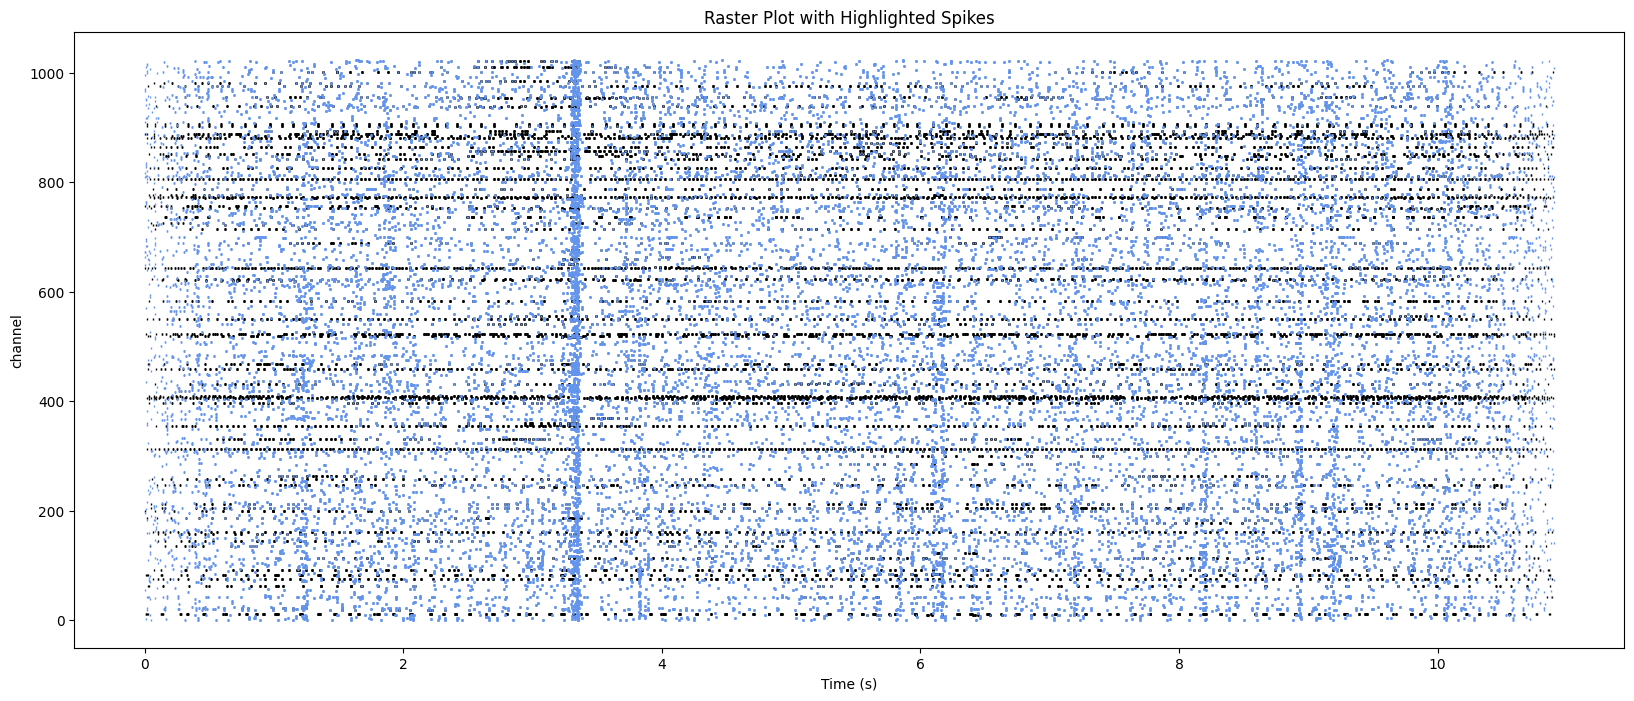

In [65]:
# Convert to Python lists
spikeTimes_list = [spikeTimes[i][0] for i in range(len(spikeTimes))]
channels_list = [channels[i][0] for i in range(len(channels))]
window_size = 1.0  # Window size in seconds
step_size = 0.1    # Step size in seconds
threshold = 10 /window_size    # Spiking rate threshold in Hz

# Placeholder for demonstration: replace with your method to obtain unit IDs and spike trains
 # Example unit IDs
#get_unit_spike_train = lambda unit_id, start_frame, end_frame: np.array([...])  # Example function

# Initialize lists for classified spike times
spike_times_below_threshold = []
spike_indices_below_threshold = []
spike_times_above_threshold = []
spike_indices_above_threshold = []
# Create a raster plot

# Plot spikes
for i, spikes in enumerate(spikeTimes_list):
    channel = channels_list[i]
    # Moving window analysis
    spike_times = np.array(spikes)
    for window_start in np.arange(0, np.max(10), step_size):
        window_end = window_start + window_size
        spikes_in_window = spike_times[(spike_times >= window_start) & (spike_times < window_end)]

        # Calculate the spiking rate
        spiking_rate = len(spikes_in_window) / window_size

        # Classify and store spike times based on the threshold
        if spiking_rate >= threshold:
            spike_times_above_threshold.extend(spikes_in_window)
            spike_indices_above_threshold.extend([channel] * len(spikes_in_window))
        else:
            spike_times_below_threshold.extend(spikes_in_window)
            spike_indices_below_threshold.extend([channel] * len(spikes_in_window))


    

# Visualization
plt.figure(figsize=(20, 8))
plt.plot(spike_times_above_threshold, spike_indices_above_threshold,marker= '|',color='black', markersize=1,ls='', label='Above Threshold')
plt.plot(spike_times_below_threshold, spike_indices_below_threshold, marker='|',color='cornflowerblue', markersize=1, ls='',label='Below Threshold')
plt.title('Raster Plot with Highlighted Spikes')
plt.xlabel('Time (s)')
plt.ylabel('channel')
#plt.legend()
plt.show()

In [40]:
channels = channels.flatten()
channels

array([   1,    2,    3, ..., 1022, 1023, 1024], dtype=int32)

In [24]:
# Dictionary to store the instantaneous frequencies for each unit
instantaneous_frequencies = {}

for unit_id in waveforms.unit_ids:
    spike_train = sorting_KS3.get_unit_spike_train(unit_id, start_frame=0, end_frame=120*fs) / fs  # Convert to seconds
    
    # Calculate differences between consecutive spike times
    spike_intervals = np.diff(spike_train)
    
    # Calculate instantaneous frequencies (Hz) and handle division by zero for isolated spikes
    with np.errstate(divide='ignore', invalid='ignore'):
        instantaneous_freq = 1.0 / spike_intervals
        instantaneous_freq[np.isinf(instantaneous_freq)] = 0  # Optional: set infinite frequencies to 0 or another value
    
    # Store the instantaneous frequencies
    instantaneous_frequencies[unit_id] = instantaneous_freq

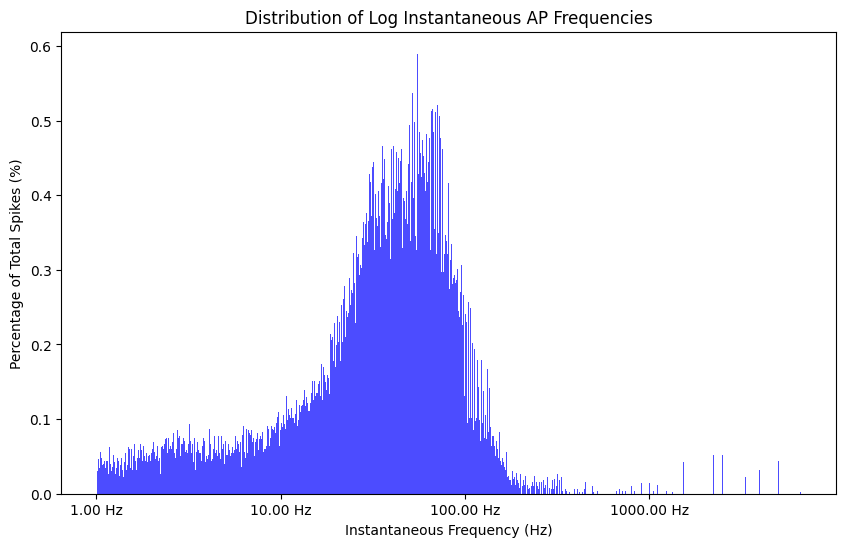

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
def log_to_hertz(value, pos):
    # Use e^value to invert the logarithm and obtain the original frequency
    return f"{np.exp(value):.2f} Hz"
# Aggregate all instantaneous frequencies across units
all_instantaneous_freqs = np.concatenate(list(instantaneous_frequencies.values()))
# Filter out non-positive frequencies to avoid undefined log values
positive_freqs = all_instantaneous_freqs[all_instantaneous_freqs > 1]

# Calculate the logarithm of positive frequencies
log_freqs = np.log(positive_freqs)
plt.figure(figsize=(10, 6))
weights = np.ones_like(log_freqs) / len(log_freqs) * 100
# Plot histogram
n, bins, patches = plt.hist(log_freqs, bins=1000, weights=weights, alpha=0.7, color='blue')

# Set the formatter for the x-axis
formatter = FuncFormatter(log_to_hertz)
plt.gca().xaxis.set_major_formatter(formatter)
 
# Set specific ticks at 1 Hz, 10 Hz, 100 Hz, and 1000 Hz
desired_ticks = [np.log(1), np.log(10), np.log(100), np.log(1000)]
plt.xticks(desired_ticks)

plt.xlabel('Instantaneous Frequency (Hz)')
plt.ylabel('Percentage of Total Spikes (%)')
plt.title('Distribution of Log Instantaneous AP Frequencies')

plt.show()

In [8]:
spike_train.shape

(765,)

In [ ]:
#si.export_to_phy(waveform_extractor=waveforms,output_folder='./sorting/SPTAN1_1_16793_phy',**job_kwargs)

In [38]:
extremum_channels_ids =si.get_template_extremum_channel(waveforms,peak_sign ='neg',mode='at_index')
extremum_channels_ids

{1: '10',
 2: '10',
 3: '921',
 4: '20',
 6: '27',
 7: '30',
 9: '40',
 10: '0',
 13: '254',
 14: '80',
 15: '83',
 16: '83',
 17: '917',
 18: '971',
 19: '83',
 20: '86',
 21: '638',
 22: '0',
 23: '172',
 24: '646',
 25: '416',
 26: '332',
 27: '392',
 28: '544',
 31: '548',
 34: '560',
 35: '762',
 36: '576',
 37: '593',
 38: '603',
 39: '605',
 40: '416',
 42: '615',
 44: '688',
 45: '688',
 46: '624',
 48: '624',
 49: '975',
 50: '1004',
 51: '625',
 52: '921',
 53: '673',
 54: '673',
 55: '638',
 56: '640',
 57: '708',
 58: '640',
 59: '640',
 60: '952',
 61: '646',
 64: '650',
 66: '941',
 67: '86',
 71: '912',
 72: '686',
 73: '688',
 74: '865',
 75: '704',
 76: '710',
 77: '710',
 78: '710',
 79: '729',
 80: '921',
 81: '710',
 82: '20',
 83: '713',
 84: '721',
 85: '721',
 86: '726',
 87: '729',
 88: '732',
 89: '735',
 90: '638',
 96: '740',
 97: '740',
 101: '815',
 102: '777',
 104: '780',
 106: '782',
 107: '788',
 108: '612',
 110: '790',
 111: '790',
 112: '726',
 115: 

In [40]:
non_violated

array([  0,   1,   2,   4,   5,   6,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  36,  37,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  54,  55,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  73,
        74,  75,  76,  77,  78,  79,  80,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 19

0


AssertionError: 'unit_id' is invalid

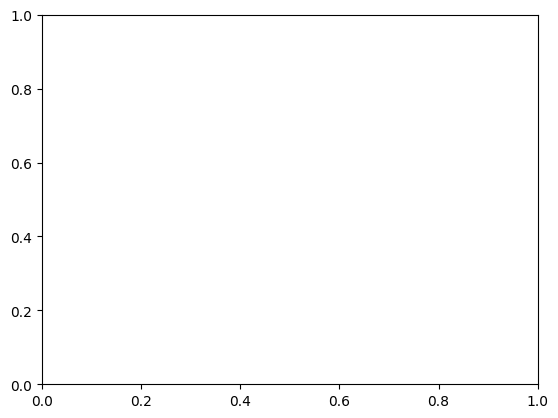

In [43]:

for i, unit_id in enumerate(non_violated):
    fig, ax = plt.subplots()
    print(unit_id)
    wf = waveforms.get_waveforms(unit_id=[unit_id])
    #print(wf.shape)
    #print(int(extremum_channels[unit_id]))
    channel_id_str = str(int(extremum_channels_ids[unit_id]))
    number = waveforms.channel_ids_to_indices([channel_id_str])
    #number =[539]
    #print(number)
    ax.plot(wf[:,:, number[0]].T,  lw=1, color='black', alpha=0.1, linestyle='-', marker='', markersize=0)
    ax.set_title(f"waveforms of a putative neuron")
    ax.set_ylabel("Amplitude (µV)")
    ax.set_xlabel("Sampled timepoints (5e-2 ms)")
    ax.set_facecolor('white')  # Set the background color to black

    # Customize the appearance of tick labels and axes
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    # ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    # ax.spines['left'].set_color('white')
    
    plt.savefig(f'/home/mmp/Documents/group_analysis/NU4/waveforms/waveforms_unit_id_{unit_id}__channel_id_{channel_id_str}_channel_index_{number[0]}.svg', format='svg',dpi=300)
    plt.close(fig)


In [61]:

job_kwargs = dict(n_jobs=16, chunk_duration="1s", progress_bar=True)
sp.compute_spike_amplitudes(waveforms,load_if_exists=True,**job_kwargs)
metrics = qm.compute_quality_metrics(waveforms,load_if_exists=False,**job_kwargs)

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:848: UserWarning: Units [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 40, 41, 42, 43, 45, 46, 48, 49, 50, 51, 55, 57, 58, 59, 60, 61, 63, 64, 65, 67, 68, 71, 73, 74, 75, 76, 77, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 122, 124, 125, 126, 127, 129, 130, 131, 133, 135, 136, 137, 143, 144, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 165, 167, 169, 171, 172, 173, 175, 177, 179, 180, 181, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 210, 211, 214, 215, 216, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236, 238, 239, 240, 242, 243, 244, 245, 246, 247, 248, 249, 25

In [62]:
import mea_analysis_pipeline
import importlib
importlib.reload(mea_analysis_pipeline)
updated_metrics = mea_analysis_pipeline.remove_violated_units(metrics)

In [15]:
non_violated = updated_metrics.index
print(len(non_violated))

NameError: name 'updated_metrics' is not defined

{0: array([1028.39176295,  305.05766872,    4.83490971]), 1: array([1056.20117303,  128.83362256,    3.45669084]), 2: array([773.89625134,  32.37397754,   1.75231825]), 3: array([933.30935212, 259.77429838,   8.8820764 ]), 4: array([950.4499648 , 240.24987071,   4.14636735]), 5: array([752.3577603 , 268.97970665,   2.88462844]), 6: array([768.89585118,  17.22187986,   1.24945802]), 7: array([855.71335624,  55.92142665,  12.94203143]), 8: array([855.29792135,  56.91906134,  57.55491788]), 9: array([1029.0178007 ,  304.84246614,    6.3118845 ]), 10: array([922.88556751, 326.42751533,   6.61201197]), 11: array([1074.87916221,  360.07368181,   13.6001644 ]), 12: array([954.77922561,  11.31380842,   4.7793845 ]), 13: array([955.36930885,  11.28579769,   3.94631672]), 14: array([915.06823865, 343.59395533,   3.15135355]), 15: array([1178.80763834,  131.5419072 ,    2.30074726]), 16: array([1516.88153475,  297.91448691,   12.97811054]), 17: array([1523.61403692,  135.66335719,    1.73940149])

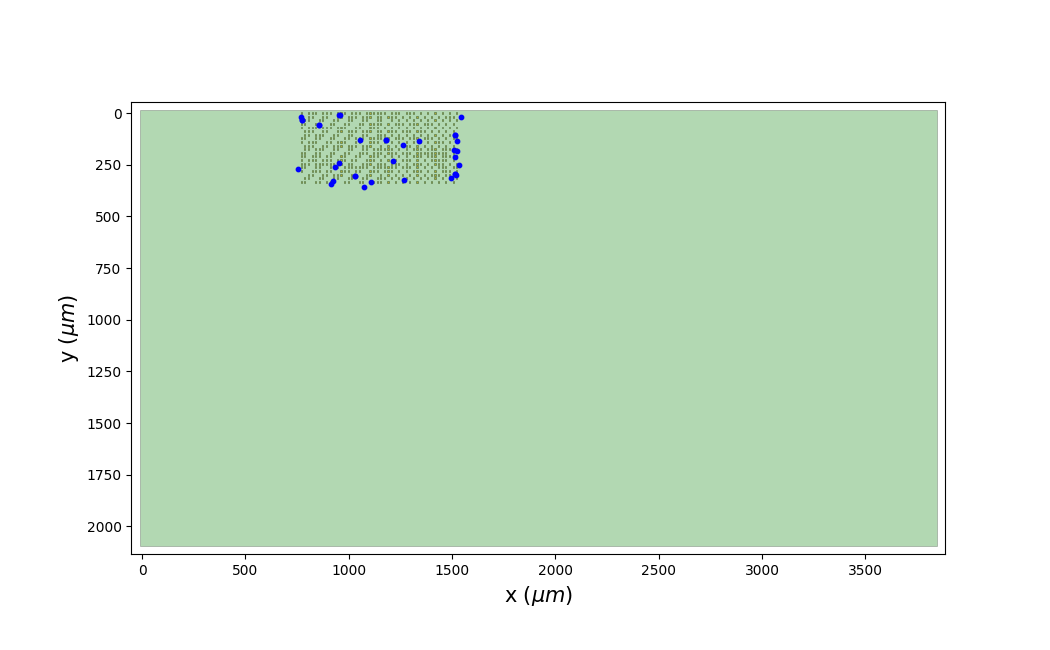

In [14]:

#locations = sp.compute_unit_locations(waveforms)
#non_violated = updated_metrics.index
unit_ids = waveforms.unit_ids
locations = si.compute_unit_locations(waveforms)
#print(locations)
unit_locations =dict(zip(unit_ids,locations))
print(unit_locations)
#np.savetxt("unitloc_10mins.txt",locations)
fig,ax = plt.subplots(figsize=(10.5,6.5))
si.plot_probe_map(recording1,ax=ax,with_channel_ids=False)
#ax.set_facecolor('#000000') 
#print(len(non_violated))
for unit_id, (x,y,z) in unit_locations.items() :
    #if unit_id in non_violated:
    ax.scatter(x,y, s=10,c='blue')
    
ax.invert_yaxis()
#plt.savefig(f'/home/mmp/Documents/NeuronalUnitsExperiment/NU_01.svg',format='svg')

In [76]:
print(len(templates))
templates.shape

438


(438, 30, 1004)

In [4]:
import spikeinterface.full as si
local_path= '/mnt/disk20tb/PrimaryNeuronData/Maxtwo/Folic_Acid_T2/Folic_Acid_T2/240206/M07039/Network/000036/data.raw.h5' #network data from chip 16848


recording1 = si.read_maxwell(local_path,stream_id='well000')
#sortingKS3 = si.Kilosort2Sorter._get_result_from_folder('/mnt/disk15tb/mmpatil/MEA_Analysis/AnalyzedData/Folic_Acid_T2/Folic_Acid_T2/240206/M07039/Network/000036/kilosort2__well000_rec0000/')
waveforms=si.load_waveforms('/mnt/disk15tb/mmpatil/MEA_Analysis/AnalyzedData/Folic_Acid_T2/Folic_Acid_T2/240206/M07039/Network/000036/waveforms_well000_rec0000/')
job_kwargs = dict(n_jobs=16, chunk_duration="1s", progress_bar=True)

metrics = si.compute_quality_metrics(waveforms,load_if_exists=False,**job_kwargs)



/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:848: UserWarning: Units [0, 3, 4, 6, 7, 8, 9, 10, 11, 14, 15, 16, 18, 19, 21, 22, 23, 25, 26, 28, 30, 31, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 47, 48, 49, 52, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 67, 69, 70, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 123, 125, 126, 127, 128, 129, 130, 133, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 147, 148, 149, 152, 153, 154, 157, 158, 159, 160, 161, 163, 164, 166, 167, 168, 169, 170, 171, 172, 175, 176, 177, 179, 180, 181, 182, 183, 184, 186, 187, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199, 202, 203, 204, 207, 208, 209, 210, 211, 213, 214, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 230, 231, 232, 234, 235, 236, 237, 238, 239, 240, 241, 244, 245, 246, 247, 248, 249, 250, 251, 253, 257,

NameError: name 'mea_analysis_pipeline' is not defined

In [5]:
import mea_analysis_pipeline
updated_metrics = mea_analysis_pipeline.remove_violated_units(metrics)
non_violated = updated_metrics.index.values


In [23]:
update_metrics

,amplitude_cutoff,amplitude_cv,amplitude_median,firing_range,firing_rate,isi_violations_ratio,isi_violations_count,num_spikes,presence_ratio,rp_contamination,rp_violations,sd_ratio,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8
1,NaN,NaN,547.599792,1.42,0.82,0.0,0.0,82.0,1.0,0.0,0.0,NaN,NaN,58.014359,0.195122,0.012195,0.0
2,NaN,NaN,597.953796,0.80,0.21,0.0,0.0,21.0,1.0,0.0,0.0,NaN,NaN,61.442806,0.333333,0.000000,0.0
3,NaN,NaN,37.765503,0.61,0.23,0.0,0.0,23.0,1.0,0.0,0.0,NaN,NaN,59.619030,0.130435,0.000000,0.0
6,NaN,NaN,365.066528,9.40,4.60,0.0,0.0,460.0,1.0,0.0,0.0,NaN,0.245,38.152691,0.265217,0.006522,0.0
7,0.500000,NaN,409.126282,2.29,33.97,0.0,0.0,3397.0,1.0,0.0,0.0,NaN,0.005,39.573593,0.272888,0.005299,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0.009736,NaN,365.066528,5.02,20.75,0.0,0.0,2075.0,1.0,0.0,0.0,NaN,0.005,35.916557,0.288193,0.004337,0.0
264,NaN,NaN,12.588501,0.61,0.25,0.0,0.0,25.0,1.0,0.0,0.0,NaN,NaN,7.743142,0.200000,0.000000,0.0
265,0.469960,NaN,383.949280,1.43,55.45,0.0,0.0,5545.0,1.0,0.0,0.0,NaN,0.005,39.776001,0.276646,0.004328,0.0
266,NaN,NaN,302.124023,2.62,4.38,0.0,0.0,438.0,1.0,0.0,0.0,NaN,0.065,31.973619,0.280822,0.004566,0.0


In [50]:
import pandas as pd
x = si.compute_unit_locations(waveforms)
#print(x)
# Convert x to a DataFrame
x_df = pd.DataFrame(x, columns=['LocX', 'LocY', 'LocZ'], index=waveforms.unit_ids)

# Merge the dataframes vertically
combined_df = metrics
combined_df['LocX'] = x_df['LocX']
combined_df['LocY'] = x_df['LocY']

# Print the combined dataframe
combined_df


,amplitude_cutoff,amplitude_cv,amplitude_median,firing_range,firing_rate,isi_violations_ratio,isi_violations_count,num_spikes,presence_ratio,rp_contamination,rp_violations,sd_ratio,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8,LocX,LocY,LocZ
1,NaN,NaN,547.599792,1.42,0.82,0.000000,0.0,82.0,1.0,0.0,0.0,NaN,NaN,58.014359,0.195122,0.012195,0.0,1162.047136,896.046940,1.000000
2,NaN,NaN,597.953796,0.80,0.21,0.000000,0.0,21.0,1.0,0.0,0.0,NaN,NaN,61.442806,0.333333,0.000000,0.0,1161.850543,896.017031,1.000000
3,NaN,NaN,37.765503,0.61,0.23,0.000000,0.0,23.0,1.0,0.0,0.0,NaN,NaN,59.619030,0.130435,0.000000,0.0,1161.857090,896.031834,1.095216
4,0.062849,NaN,522.422791,2.85,7.19,3.481887,54.0,719.0,1.0,1.0,54.0,NaN,NaN,51.727955,0.299026,0.002782,0.0,1083.072622,575.146423,1.000000
6,NaN,NaN,365.066528,9.40,4.60,0.000000,0.0,460.0,1.0,0.0,0.0,NaN,0.245,38.152691,0.265217,0.006522,0.0,3515.702658,872.872892,1.198640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0.009736,NaN,365.066528,5.02,20.75,0.000000,0.0,2075.0,1.0,0.0,0.0,NaN,0.005,35.916557,0.288193,0.004337,0.0,1887.158119,853.244562,NaN
264,NaN,NaN,12.588501,0.61,0.25,0.000000,0.0,25.0,1.0,0.0,0.0,NaN,NaN,7.743142,0.200000,0.000000,0.0,2362.664539,577.741826,NaN
265,0.469960,NaN,383.949280,1.43,55.45,0.000000,0.0,5545.0,1.0,0.0,0.0,NaN,0.005,39.776001,0.276646,0.004328,0.0,1270.491246,1937.650805,NaN
266,NaN,NaN,302.124023,2.62,4.38,0.000000,0.0,438.0,1.0,0.0,0.0,NaN,0.065,31.973619,0.280822,0.004566,0.0,2101.669615,1173.974985,NaN


In [31]:
import mea_analysis_pipeline
updated_metrics = mea_analysis_pipeline.remove_violated_units(combined_df)
non_violated = updated_metrics.index.values

array([1.16204714e+03, 8.96046940e+02, 1.00000000e+00])

In [7]:
qual_metrics = metrics.loc[non_violated]
qual_metrics.to_excel(f"./quality_metrics.xlsx")

In [111]:
import os
extremum_channels_ids =si.get_template_extremum_channel(waveforms,peak_sign ='neg',mode='at_index')
templates = waveforms.get_all_templates(unit_ids=non_violated.values)
output_folder = '/home/mmp/Documents/templates_plots_NU_2'
channel_ids = recording1.get_channel_ids()
# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for idx,unit_id in enumerate(non_violated.values):
    template = templates[idx]
    fig, ax = plt.subplots()
    plt.plot(template, color='black', alpha=0.5)
    plt.plot(template[:,list(channel_ids).index(extremum_channels_ids[unit_id])] , color='red')
                                            
    plt.savefig(os.path.join(output_folder, f'template_unit_{unit_id}.png'))
    plt.close(fig)



In [121]:
spike_trains = []
for unit_id in non_violated.values:
    spike_train = sortingKS3.get_unit_spike_train(unit_id=unit_id)
    spike_trains.append(spike_train)




In [33]:
fs=recording1.get_sampling_frequency()
t_start = 0 
t_end = int(300 * fs)
dt = 1
frame_numbers = t_end
spike_array = np.zeros((len(non_violated),frame_numbers), dtype= int)
for idx, unit_id in enumerate(non_violated):
    spike_train = sortingKS3.get_unit_spike_train(unit_id,start_frame=t_start,end_frame=t_end)
    for spike_time in spike_train:
        spike_array[idx,spike_time] = 1


In [34]:
spike_array.shape

(184, 3000000)

In [35]:
import scipy.signal as signal

# Define the original sampling frequency and the target sampling frequency
original_fs = recording1.get_sampling_frequency()
target_fs = 100

# Calculate the resampling factor
resampling_factor = original_fs / target_fs

# Resample the spike_array
downsampled_spike_array = signal.resample(spike_array, int(spike_array.shape[1] / resampling_factor), axis=1)


In [36]:
downsampled_spike_array.shape

(184, 30000)

In [51]:
import numpy as np
import scipy.io as sio

# Save as .npz format
np.savez('KCNT1_T3_NU4_63_01.npz', data=downsampled_spike_array)

# Save as .mat format
sio.savemat('KCNT1_T3_NU4_63_01.mat', {'data': downsampled_spike_array})

combined_df.to_excel('KCNT1_T3_NU4_63_01.xlsx', index=False)



In [52]:
combined_df

,amplitude_cutoff,amplitude_cv,amplitude_median,firing_range,firing_rate,isi_violations_ratio,isi_violations_count,num_spikes,presence_ratio,rp_contamination,rp_violations,sd_ratio,sliding_rp_violation,snr,sync_spike_2,sync_spike_4,sync_spike_8,LocX,LocY,LocZ
1,NaN,NaN,547.599792,1.42,0.82,0.000000,0.0,82.0,1.0,0.0,0.0,NaN,NaN,58.014359,0.195122,0.012195,0.0,1162.047136,896.046940,1.000000
2,NaN,NaN,597.953796,0.80,0.21,0.000000,0.0,21.0,1.0,0.0,0.0,NaN,NaN,61.442806,0.333333,0.000000,0.0,1161.850543,896.017031,1.000000
3,NaN,NaN,37.765503,0.61,0.23,0.000000,0.0,23.0,1.0,0.0,0.0,NaN,NaN,59.619030,0.130435,0.000000,0.0,1161.857090,896.031834,1.095216
4,0.062849,NaN,522.422791,2.85,7.19,3.481887,54.0,719.0,1.0,1.0,54.0,NaN,NaN,51.727955,0.299026,0.002782,0.0,1083.072622,575.146423,1.000000
6,NaN,NaN,365.066528,9.40,4.60,0.000000,0.0,460.0,1.0,0.0,0.0,NaN,0.245,38.152691,0.265217,0.006522,0.0,3515.702658,872.872892,1.198640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0.009736,NaN,365.066528,5.02,20.75,0.000000,0.0,2075.0,1.0,0.0,0.0,NaN,0.005,35.916557,0.288193,0.004337,0.0,1887.158119,853.244562,NaN
264,NaN,NaN,12.588501,0.61,0.25,0.000000,0.0,25.0,1.0,0.0,0.0,NaN,NaN,7.743142,0.200000,0.000000,0.0,2362.664539,577.741826,NaN
265,0.469960,NaN,383.949280,1.43,55.45,0.000000,0.0,5545.0,1.0,0.0,0.0,NaN,0.005,39.776001,0.276646,0.004328,0.0,1270.491246,1937.650805,NaN
266,NaN,NaN,302.124023,2.62,4.38,0.000000,0.0,438.0,1.0,0.0,0.0,NaN,0.065,31.973619,0.280822,0.004566,0.0,2101.669615,1173.974985,NaN
